## Objective
Examine spikes in raw data, especially those with too large amplitudes

In [ ]:
%load_ext autoreload
%autoreload

# from importlib import reload
# from src import plot
# reload(plot)
# from src.plot import plot_hist_percents

# Update PATH to allow imports
# import sys
# if '/data/MEAprojects/DLSpikeSorter' in sys.path:
#     sys.path.remove('/data/MEAprojects/DLSpikeSorter')

import numpy as np
import matplotlib.pyplot as plt
from spikeinterface.extractors import NwbRecordingExtractor
from spikeinterface.preprocessing import bandpass_filter
from pathlib import Path
from matplotlib.ticker import PercentFormatter

In [53]:
def set_dpi(dpi):
    import matplotlib as mpl
    mpl.rcParams["figure.dpi"] = dpi


def plot_hist_percents(data, decimals=None, **hist_kwargs):
    # Plot a histogram with percents as y-axis
    # https://www.geeksforgeeks.org/matplotlib-ticker-percentformatter-class-in-python/
    plt.hist(data, weights=np.ones(len(data)) / len(data), **hist_kwargs)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=decimals))


In [4]:
def plot_trace(start_frame, end_frame, channel_ind):
    fig, (a0, a1) = plt.subplots(1, 2, figsize=(10, 6))
    a0.set_title("Raw traces")
    a1.set_title("Filtered traces")

    # x_values = np.arange(start_frame, end_frame) / rec.get_sampling_frequency() * 1000
    x_values = np.arange(end_frame-start_frame)

    for a in (a0, a1):
        a.set_xlabel("Frames")  # a.set_xlabel("Milliseconds")
        a.set_xlim(x_values[0], x_values[-1])
        a.set_ylabel("Microvolts")

    channel_ids = np.atleast_1d(rec.get_channel_ids()[channel_ind])

    rec_traces = rec.get_traces(start_frame=start_frame, end_frame=end_frame, channel_ids=channel_ids, return_scaled=True)
    for trace in rec_traces.T:
        a0.plot(x_values, trace)
    filtered_traces = filtered.get_traces(start_frame=start_frame, end_frame=end_frame, channel_ids=channel_ids, return_scaled=True)
    for trace in filtered_traces.T:
        a1.plot(x_values, trace)

    plt.show()

In [5]:
# Load recording
REC_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/sub-mouse412804_ecephys.nwb"
FREQ_MIN = 300
FREQ_MAX = 3000
##
rec = NwbRecordingExtractor(REC_PATH)
filtered = bandpass_filter(rec, freq_min=FREQ_MIN, freq_max=FREQ_MAX, dtype="float32")

/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


In [6]:
# Load kilosort2
# Folder containing kilosort's outputs
KS_FOLDER = "/data/MEAprojects/dandi/000034/sub-mouse412804/ensemble_sorting_of_a_neuropixels_recording/working_15min/rec/kilosort2"
##
class Kilosort:
    def __init__(self, folder):
        self.folder = Path(folder)

    def get_amplitudes(self):
        return np.load(self.folder / "amplitudes.npy", mmap_mode="r").flatten()

    def get_spike_clusters(self):
        return np.load(self.folder / "spike_clusters.npy", mmap_mode="r").flatten().astype(int)

    def get_spike_times(self):
        return np.load(self.folder / "spike_times.npy", mmap_mode="r").flatten().astype(int)

    def get_templates(self):
        return np.load(self.folder / "templates.npy", mmap_mode="r")

kilosort = Kilosort(KS_FOLDER)

In [7]:
id_to_template_max_amp = {}
id_to_max_chan = {}
templates = kilosort.get_templates()
for i in range(len(templates)):
    template = np.abs(templates[i, :, :])
    id_to_template_max_amp[i] = np.max(template)
    id_to_max_chan[i] = np.max(template, axis=0).argmax()

In [8]:
amplitudes = []
for id, amp in zip(kilosort.get_spike_clusters(), kilosort.get_amplitudes()):
    amplitudes.append(amp * id_to_template_max_amp[id])

4.037555986644406


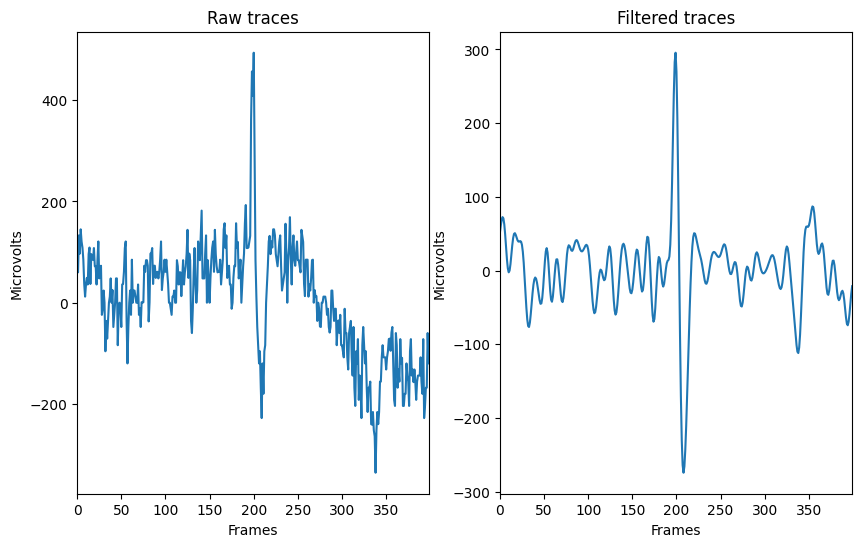

In [9]:
idx = 234144
amp = amplitudes[idx]
st = kilosort.get_spike_times()[idx]
id = kilosort.get_spike_clusters()[idx]
SIZE = 200
print(amp)
plot_trace(st-SIZE, st+SIZE, [id_to_max_chan[id]])

In [10]:
ks = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/for_tj_email_follow_up_propagation_signal_alg_test/amps_ks.npy", allow_pickle=True)

In [11]:
unit = ks[0]

In [12]:
max_amps = [0] * 5
for unit in ks:
    for st in unit:
        amp = np.max(np.abs(st))
        for i in range(len(max_amps)-1, -1, -1):
            if amp > max_amps[i]:
                if i > 0:
                    max_amps[:i] = max_amps[1:i+1]

                max_amps[i] = amp
                break

In [13]:
max_amps

[3649.106, 3667.5266, 3794.412, 3824.4766, 4145.0894]

In [20]:
# Path to spikesort_matlab4.py intermediate folder
SM4_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/spikesort_matlab4"
##
class SpikesortMatlab4:
    # Class to represent data from spikesort_matlab4.py
    def __init__(self, path):
        self.path = Path(path)

        self.path_wfs = self.path / "waveforms"

    def get_templates_mean(self):
        return np.load(self.path_wfs / "templates/templates_average.npy", mmap_mode="r")
sm4 = SpikesortMatlab4(SM4_PATH)

In [21]:
templates = sm4.get_templates_mean()

In [140]:
count = 0
curated = []
for unit in templates:
    chan_amps = np.max(np.abs(unit), axis=0)
    chan_viols = chan_amps > 30
    if np.sum(chan_viols) > 50:
        count += 1
    else:
        curated.append(np.max(chan_amps))
print(count)

21


In [134]:
unit_amps = np.max(np.abs(templates), axis=(1, 2))
set_dpi(400)

426


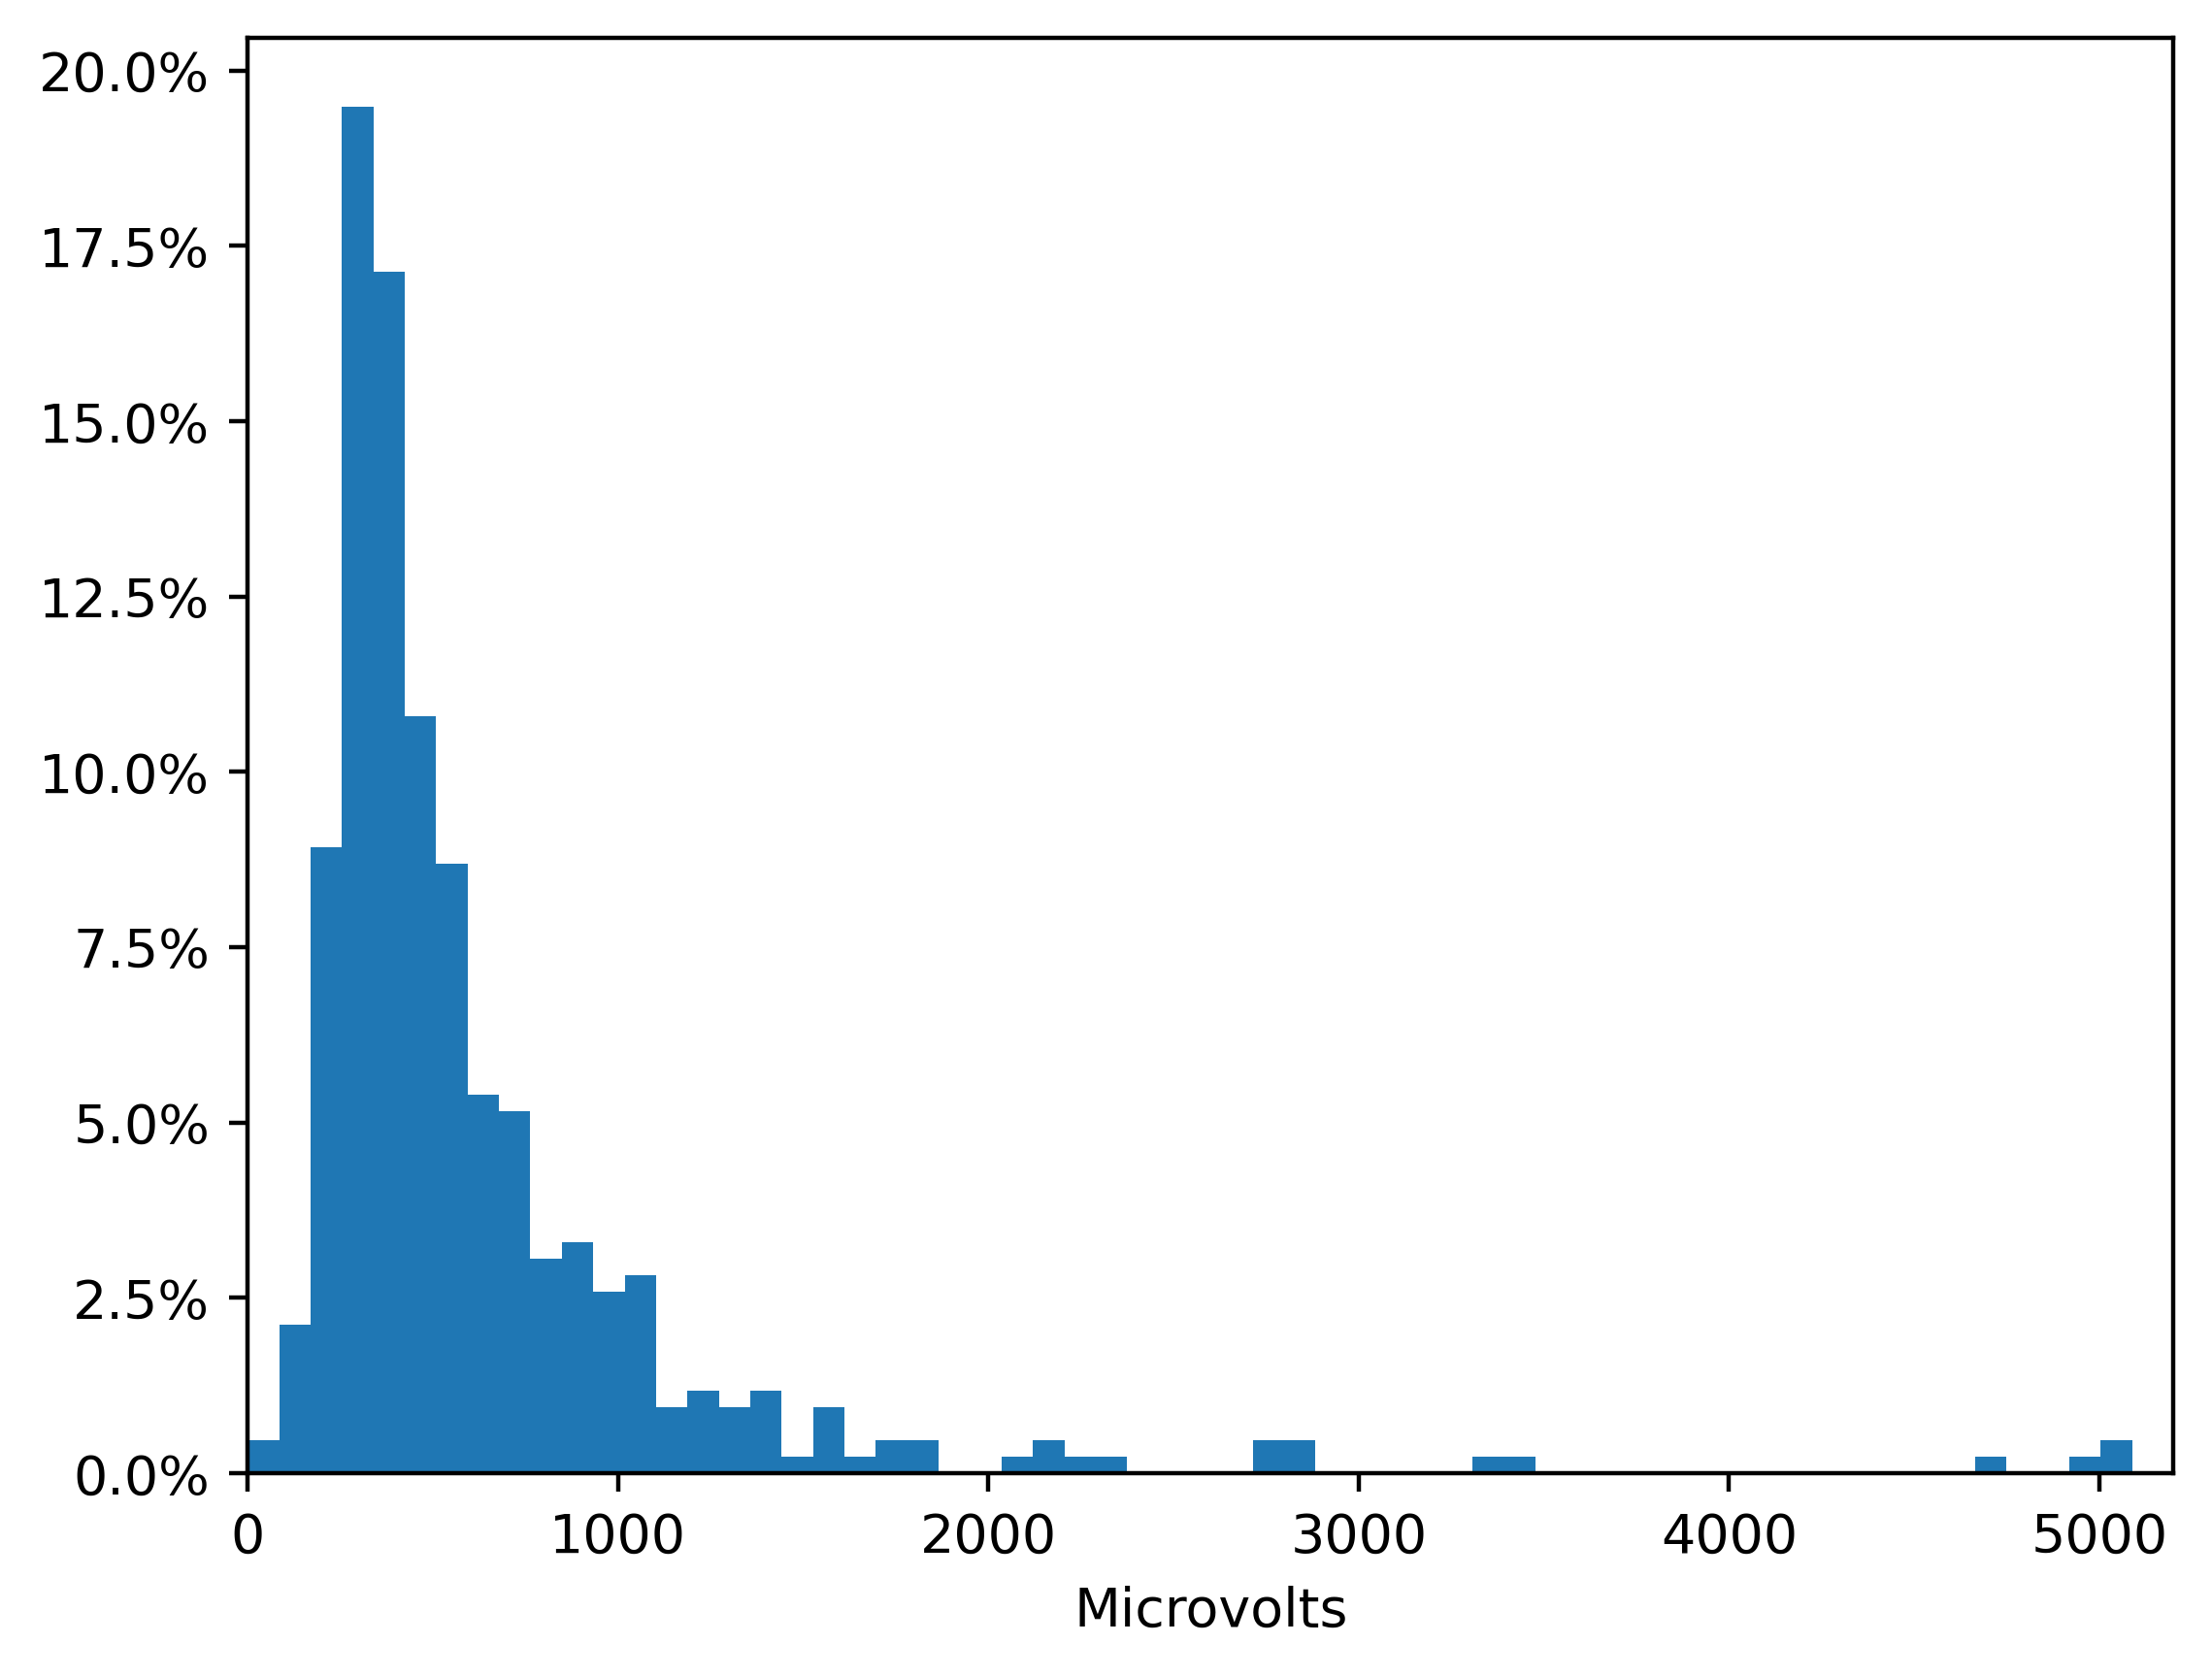

In [135]:
print(len(unit_amps))
plot_hist_percents(unit_amps, bins=60)
plt.xlabel("Microvolts")
plt.xlim(0, 5200)
plt.show()


352


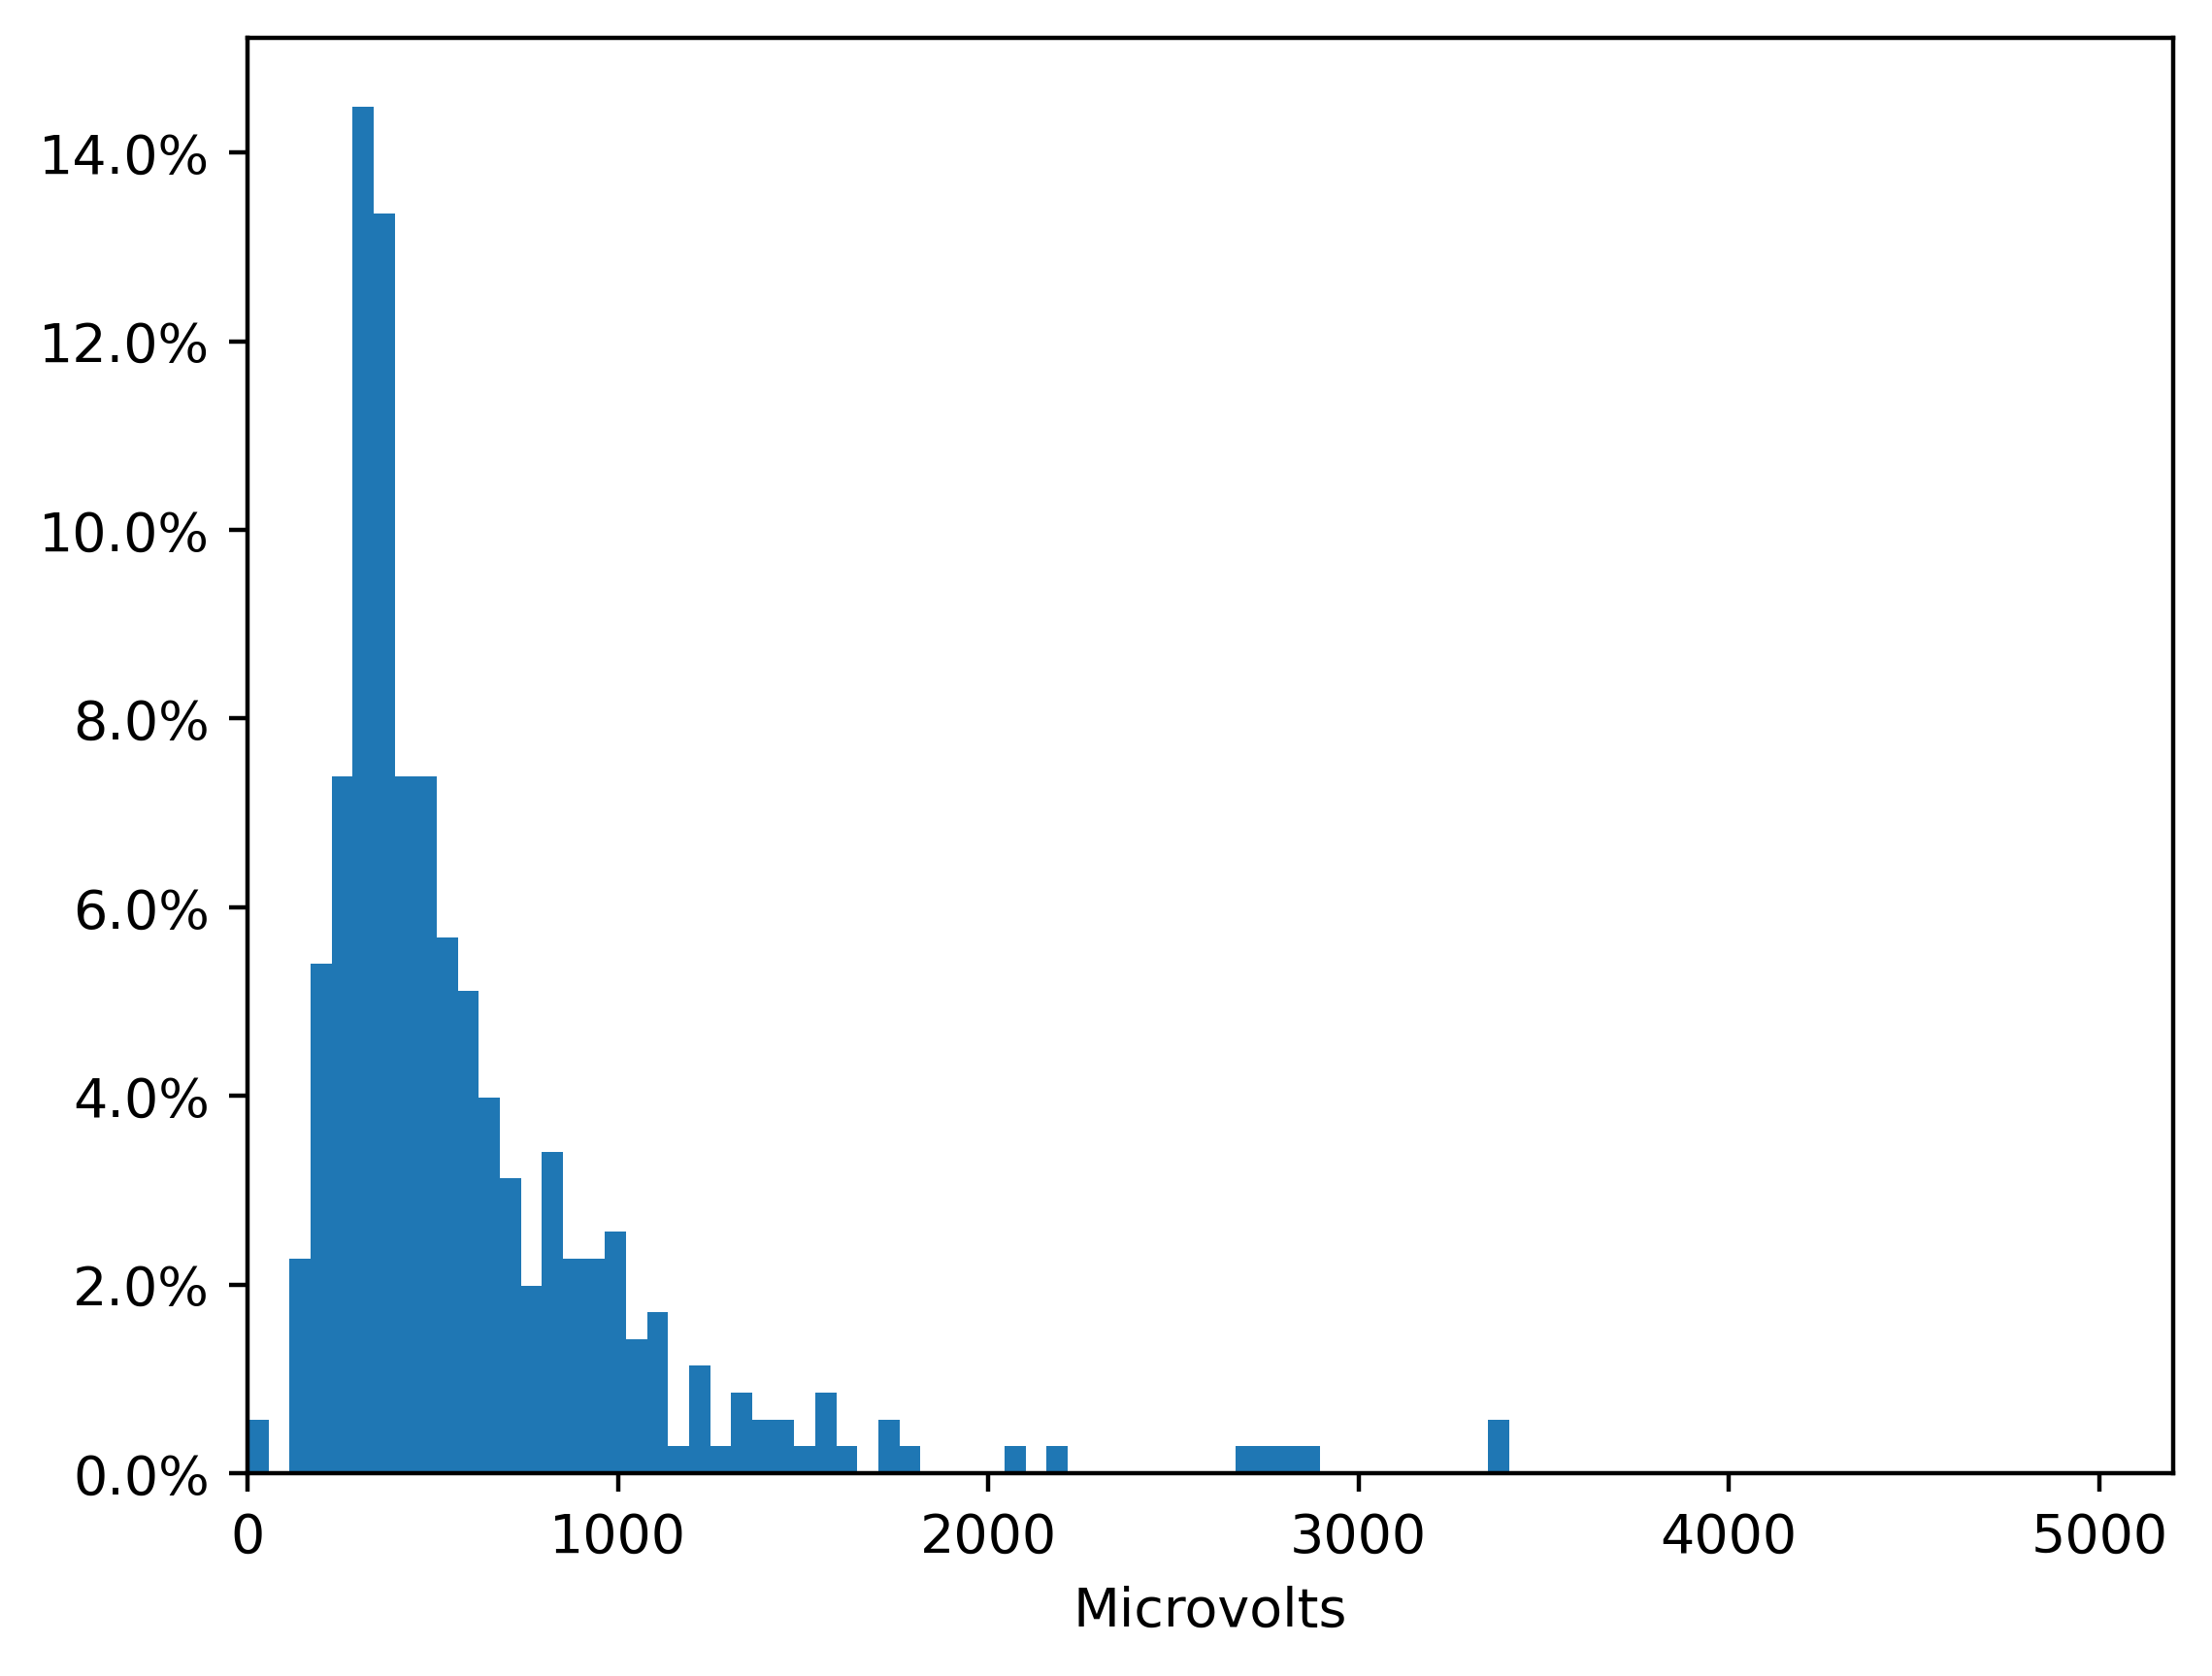

In [136]:
print(len(curated))
plot_hist_percents(curated, bins=60)
plt.xlabel("Microvolts")
plt.xlim(0, 5200)
plt.show()

In [112]:
unit_amps_curated = unit_amps[(unit_amps > 0) * (unit_amps <= 1750)]

407


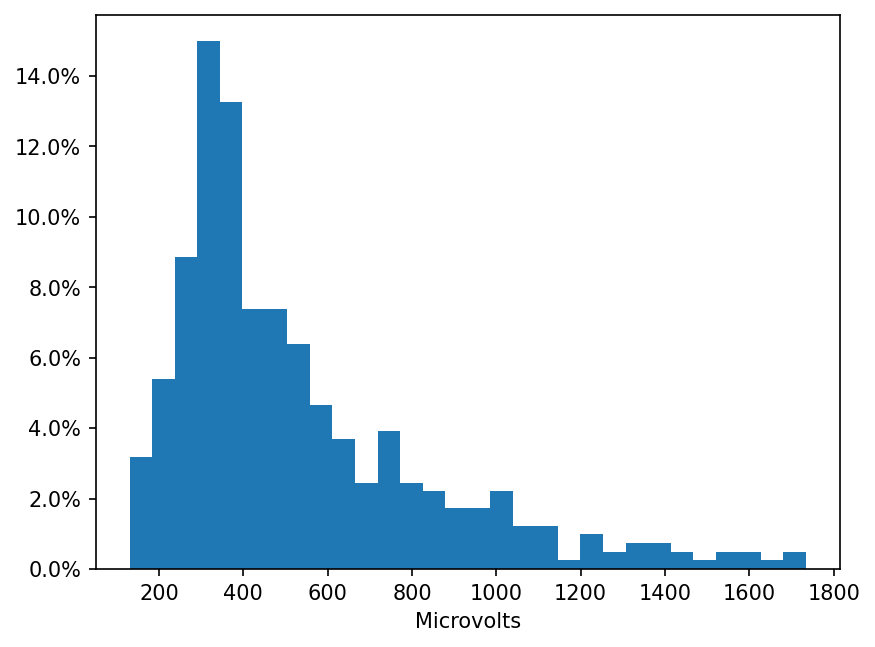

In [113]:
print(len(unit_amps_curated))
plot_hist_percents(unit_amps_curated, bins=30)
plt.xlabel("Microvolts")
plt.show()

In [101]:
np.unique(np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/ensemble_sorting_of_a_neuropixels_recording/working_15min/rec/kilosort2/spike_clusters.npy")).size

455